<a href="https://colab.research.google.com/github/febse/ts2025-presentations-2-dani-ladi/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [309]:
# NB!: change this to the student id of one of your team members

assignment_seed = "4EB0100061"

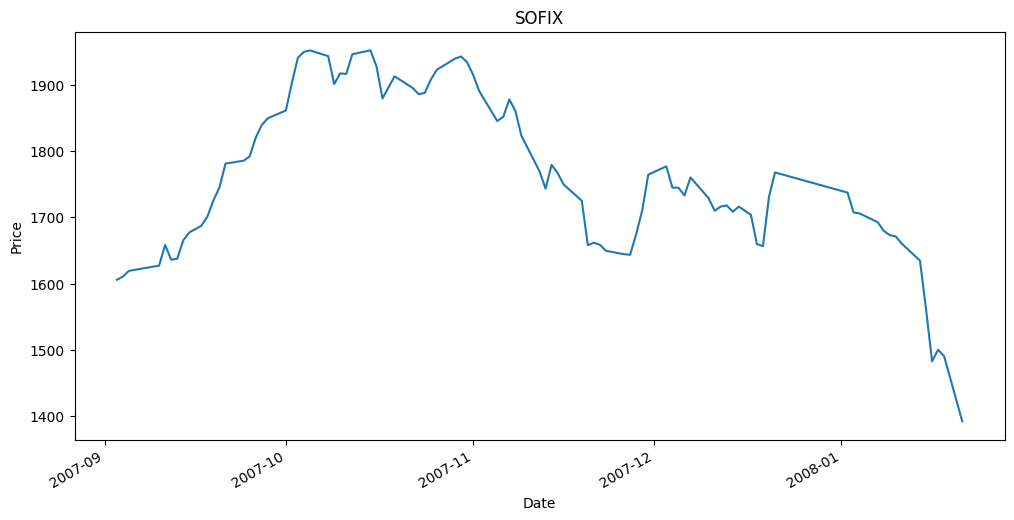

In [310]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SOFIX")
plt.show()

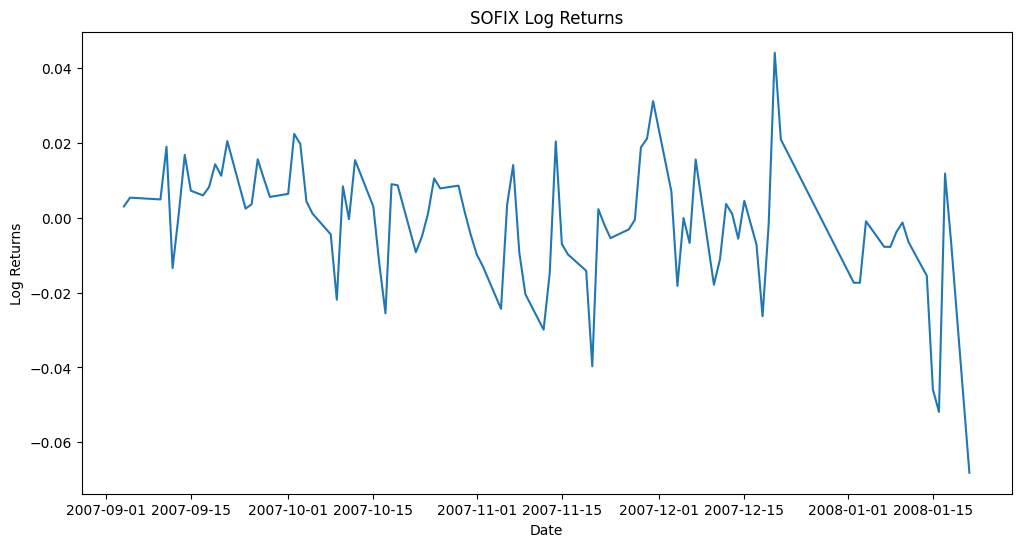

In [311]:
train_lr = np.log(train).diff()

plt.figure(figsize=(12, 6))
plt.plot(train_lr)
plt.title('SOFIX Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

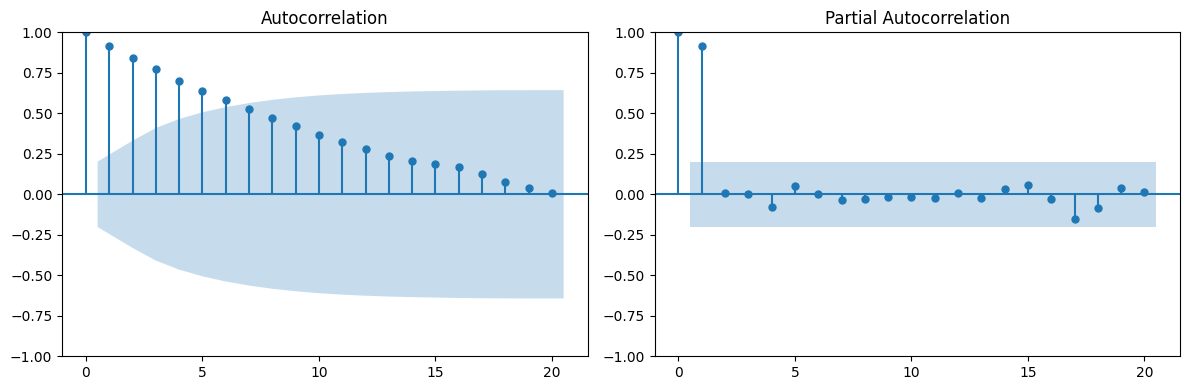

In [312]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train, ax=ax[0], lags=20)
plot_pacf(train, ax=ax[1], lags=20)
plt.tight_layout()
plt.show()

In [314]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
adf_result = adfuller(train)
print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.2f}')

if adf_result[1] > 0.05:
    print('Conclusion: The series is likely non-stationary (fail to reject H0)')
else:
    print('Conclusion: The series is likely stationary (reject H0)')

print('\n' + '='*50 + '\n')

ADF Statistic: 0.05
p-value: 0.96
Critical Values:
	1%: -3.51
	5%: -2.89
	10%: -2.58
Conclusion: The series is likely non-stationary (fail to reject H0)




In [315]:
# KPSS Test
kpss_result = kpss(train)
print(f'KPSS Statistic: {kpss_result[0]:.2f}')
print(f'p-value: {kpss_result[1]:.2f}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'\t{key}: {value:.2f}')

if kpss_result[1] < 0.05:
    print('Conclusion: The series is likely non-stationary (reject H0)')
else:
    print('Conclusion: The series is likely stationary (fail to reject H0)')

KPSS Statistic: 0.59
p-value: 0.02
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74
Conclusion: The series is likely non-stationary (reject H0)


In [317]:
train_clean = train_lr.dropna()
model_arima1 = train.dropna()
fit_ARIMA = ARIMA(model_arima1, order=(2, 1, 0)).fit()
print(fit_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  SOFIX   No. Observations:                   94
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -435.555
Date:                Sat, 10 Jan 2026   AIC                            877.110
Time:                        18:33:16   BIC                            884.708
Sample:                             0   HQIC                           880.178
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4601      0.109      4.239      0.000       0.247       0.673
ar.L2         -0.2297      0.110     -2.097      0.036      -0.445      -0.015
sigma2       682.7344     92.618      7.371      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [319]:
model_arima2 = train.dropna()
fit_ARIMA2 = ARIMA(model_arima1, order=(2, 1, 1)).fit()
print(fit_ARIMA2.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SOFIX   No. Observations:                   94
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -434.407
Date:                Sat, 10 Jan 2026   AIC                            876.815
Time:                        18:33:26   BIC                            886.945
Sample:                             0   HQIC                           880.905
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0188      0.361     -0.052      0.958      -0.725       0.688
ar.L2         -0.0637      0.185     -0.345      0.730      -0.426       0.299
ma.L1          0.5149      0.330      1.559      0.1

In [320]:
model_arima3 = train.dropna()
fit_ARIMA3 = ARIMA(model_arima1, order=(2, 2, 0)).fit()
print(fit_ARIMA3.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SOFIX   No. Observations:                   94
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -437.335
Date:                Sat, 10 Jan 2026   AIC                            880.671
Time:                        18:33:33   BIC                            888.236
Sample:                             0   HQIC                           883.724
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2321      0.105     -2.208      0.027      -0.438      -0.026
ar.L2         -0.4642      0.090     -5.147      0.000      -0.641      -0.287
sigma2       783.5308    119.296      6.568      0.0

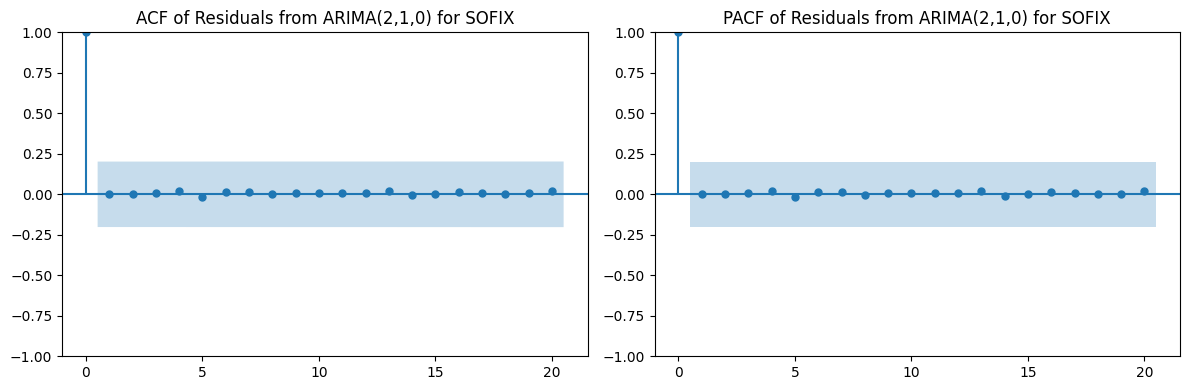

In [321]:
residuals = fit_ARIMA.resid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=20)
plot_pacf(residuals, ax=ax[1], lags=20)
ax[0].set_title(f'ACF of Residuals from ARIMA(2,1,0) for {dt.name}')
ax[1].set_title(f'PACF of Residuals from ARIMA(2,1,0) for {dt.name}')
plt.tight_layout()
plt.show()

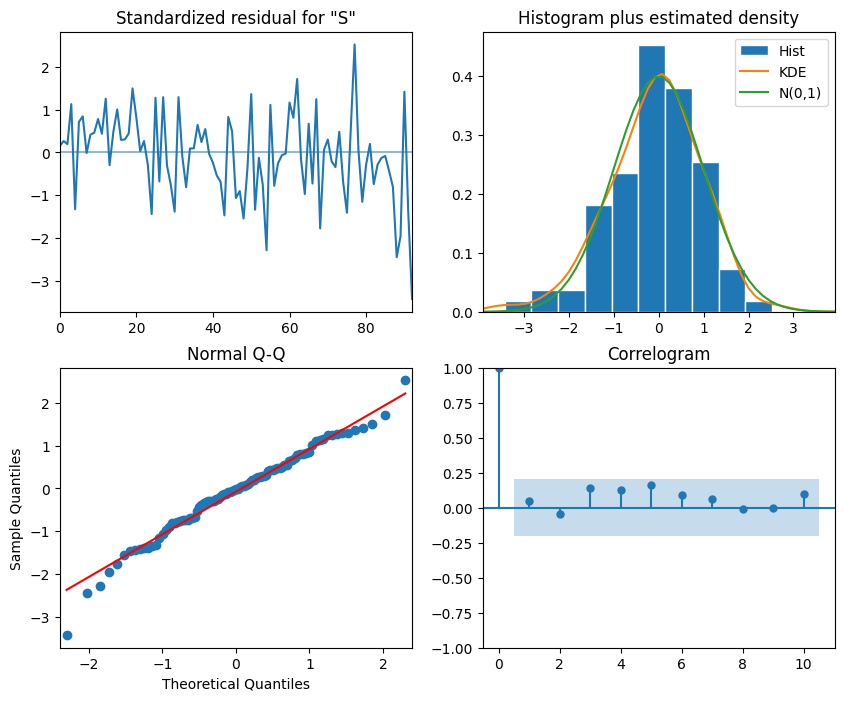

In [322]:
fit_ARIMA.plot_diagnostics(figsize=(10, 8))
plt.show()

In [323]:
lb_serial_corr = fit_ARIMA.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i + 1}, test statistic = {stat:.3f} with p-value {p:.3f}")


Lag 1, test statistic = 0.197 with p-value 0.657
Lag 2, test statistic = 0.411 with p-value 0.814
Lag 3, test statistic = 2.321 with p-value 0.508
Lag 4, test statistic = 3.915 with p-value 0.418
Lag 5, test statistic = 6.654 with p-value 0.248
Lag 6, test statistic = 7.501 with p-value 0.277
Lag 7, test statistic = 7.914 with p-value 0.340
Lag 8, test statistic = 7.924 with p-value 0.441
Lag 9, test statistic = 7.924 with p-value 0.542
Lag 10, test statistic = 8.889 with p-value 0.543


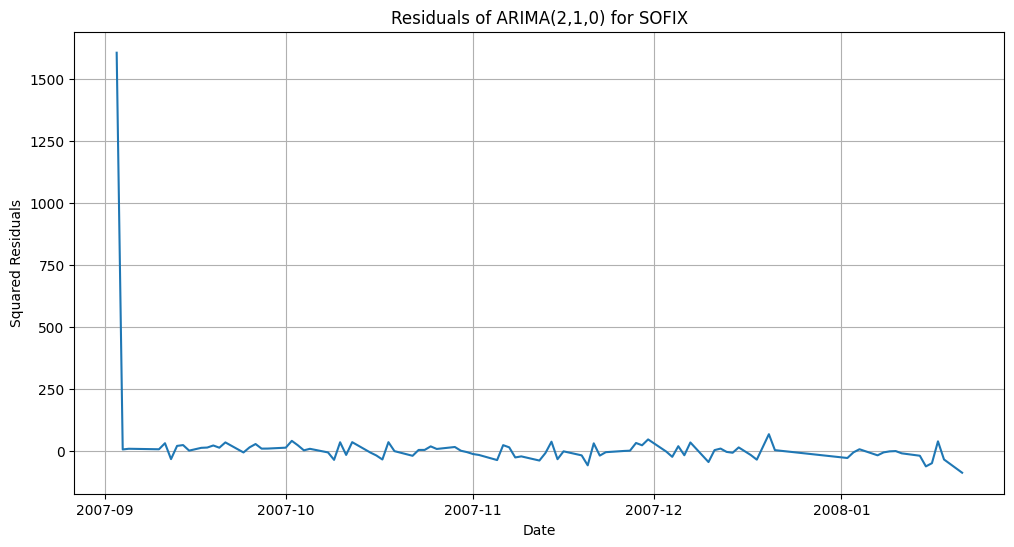

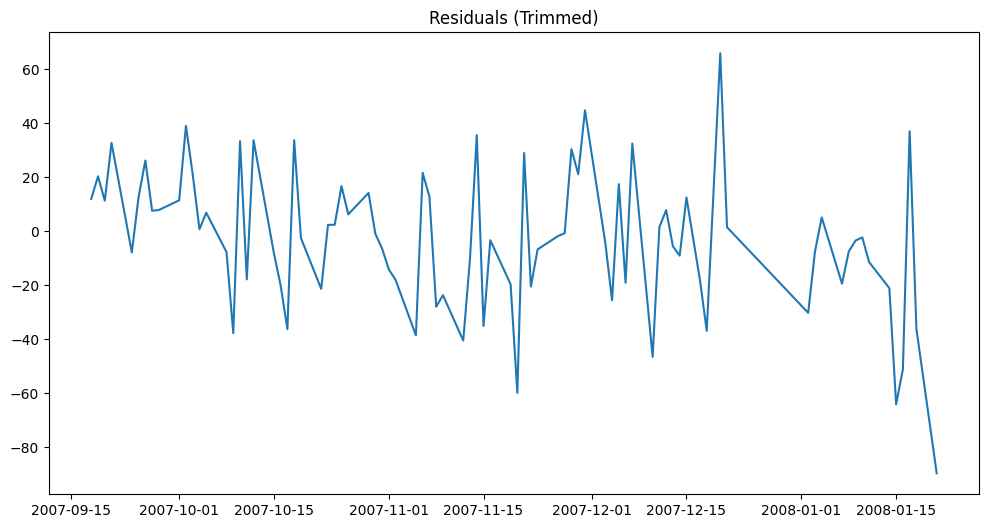

In [327]:
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals)
plt.title(f'Residuals of ARIMA(2,1,0) for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.show()

cleaned_residuals = residuals[10:]
plt.figure(figsize=(12, 6))
plt.plot(cleaned_residuals.index, cleaned_residuals)
plt.title('Residuals (Trimmed)')
plt.show()

In [345]:
from arch import arch_model

am = arch_model(train_lr_pct,
                mean='AR',
                lags=2,
                vol='Garch',
                p=1, q=1,
                dist='t')
fit_GARCH11 = am.fit(disp='off')
print(fit_GARCH11.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        SOFIX   R-squared:                       0.139
Mean Model:                              AR   Adj. R-squared:                  0.120
Vol Model:                            GARCH   Log-Likelihood:               -164.172
Distribution:      Standardized Student's t   AIC:                           342.343
Method:                  Maximum Likelihood   BIC:                           359.919
                                              No. Observations:                   91
Date:                      Sat, Jan 10 2026   Df Residuals:                       88
Time:                              18:40:39   Df Model:                            3
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

In [346]:
clean_residuals = fit_GARCH11.std_resid.dropna()

ljung_box = acorr_ljungbox(clean_residuals, lags=[1, 5, 10, 20], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
1    0.108004   0.742428
5    4.511812   0.478305
10   6.657539   0.757331
20  11.801560   0.922737


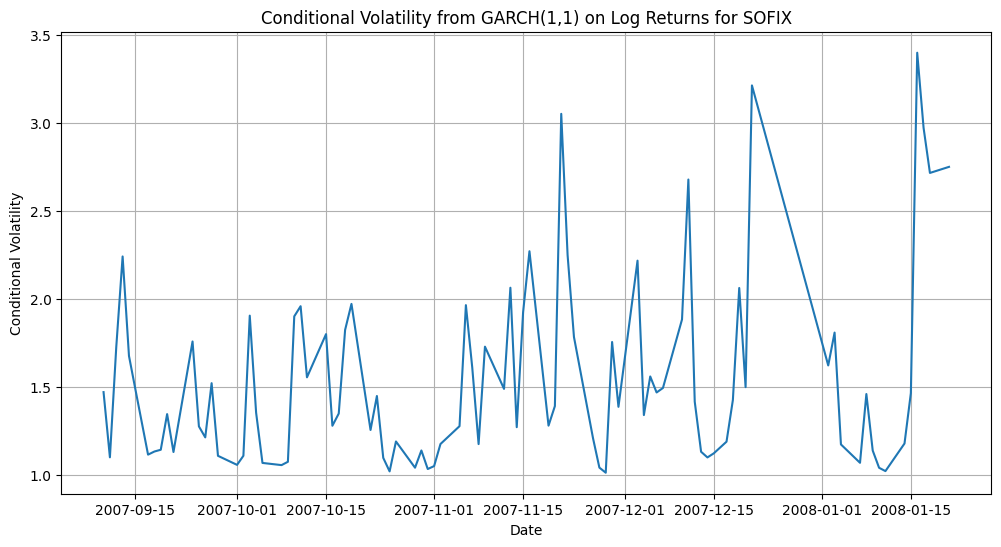

In [347]:
plt.figure(figsize=(12, 6))
plt.plot(fit_GARCH11.conditional_volatility)
plt.title(f'Conditional Volatility from GARCH(1,1) on Log Returns for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

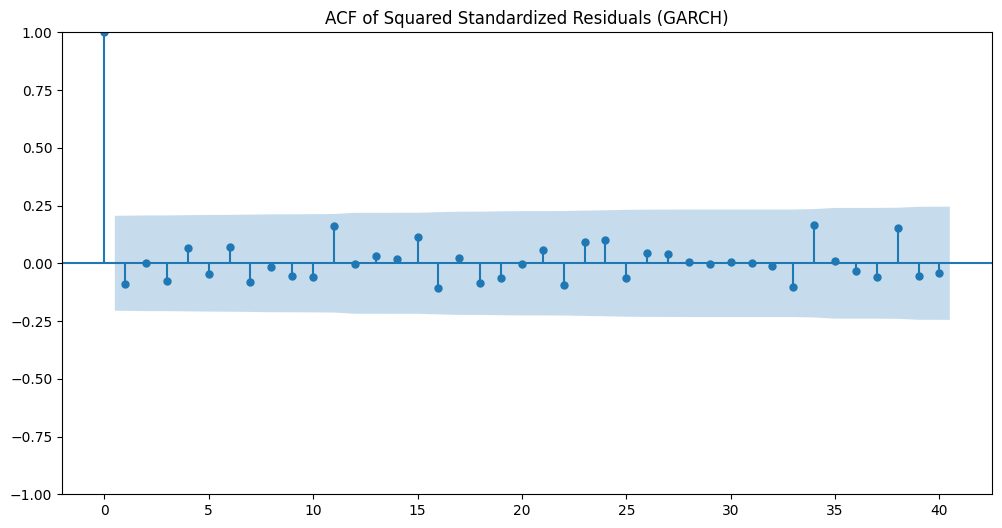

In [348]:
clean_squared_resid = clean_residuals**2

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(clean_squared_resid, lags=40, ax=ax)
ax.set_title('ACF of Squared Standardized Residuals (GARCH)')
plt.show()

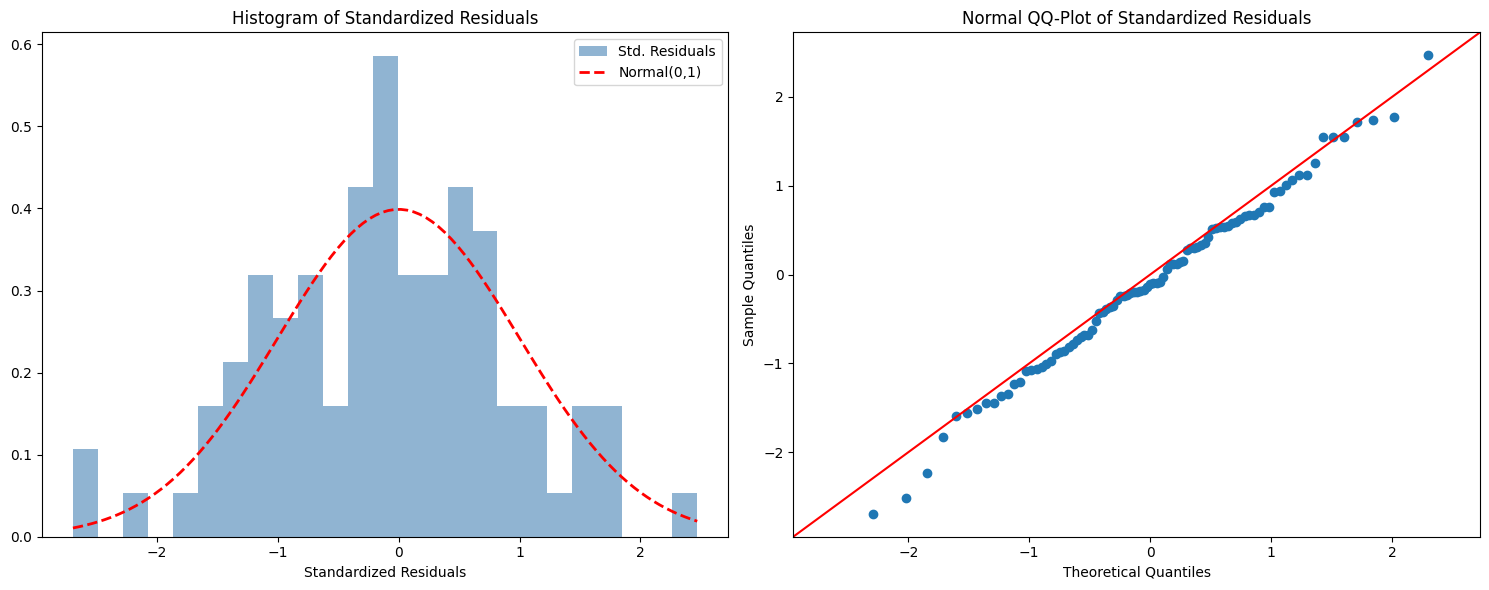

In [349]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

clean_residuals = fit_GARCH11.std_resid.dropna()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(clean_residuals, bins=25, density=True, alpha=0.6, color='steelblue', label='Std. Residuals')

x = np.linspace(clean_residuals.min(), clean_residuals.max(), 100)
ax[0].plot(x, stats.norm.pdf(x, 0, 1), 'r--', lw=2, label='Normal(0,1)')

ax[0].set_title('Histogram of Standardized Residuals')
ax[0].set_xlabel('Standardized Residuals')
ax[0].legend()

sm.qqplot(clean_residuals, line='45', ax=ax[1])
ax[1].set_title('Normal QQ-Plot of Standardized Residuals')

plt.tight_layout()
plt.show()

In [351]:
model_arma = train_lr.dropna()
fit_ARMA = ARIMA(model_arma, order=(2, 0, 0)).fit()
print(fit_ARMA.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SOFIX   No. Observations:                   93
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 255.038
Date:                Sat, 10 Jan 2026   AIC                           -502.076
Time:                        18:40:52   BIC                           -491.946
Sample:                             0   HQIC                          -497.986
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.744      0.457      -0.006       0.003
ar.L1          0.4605      0.106      4.326      0.000       0.252       0.669
ar.L2         -0.2355      0.113     -2.093      0.0

In [352]:
forecast = fit_ARIMA.forecast(steps=10)
print("10-step Forecast:")
print(forecast)

10-step Forecast:
94     1349.026701
95     1351.845472
96     1362.996814
97     1367.479924
98     1366.980648
99     1365.720970
100    1365.256101
101    1365.331618
102    1365.473163
103    1365.520939
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [353]:
forecast = fit_ARMA.forecast(steps=10)
print("10-step Forecast:")
print(forecast)

10-step Forecast:
93    -0.031170
94     0.000350
95     0.006155
96     0.001404
97    -0.002151
98    -0.002669
99    -0.002070
100   -0.001672
101   -0.001630
102   -0.001704
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


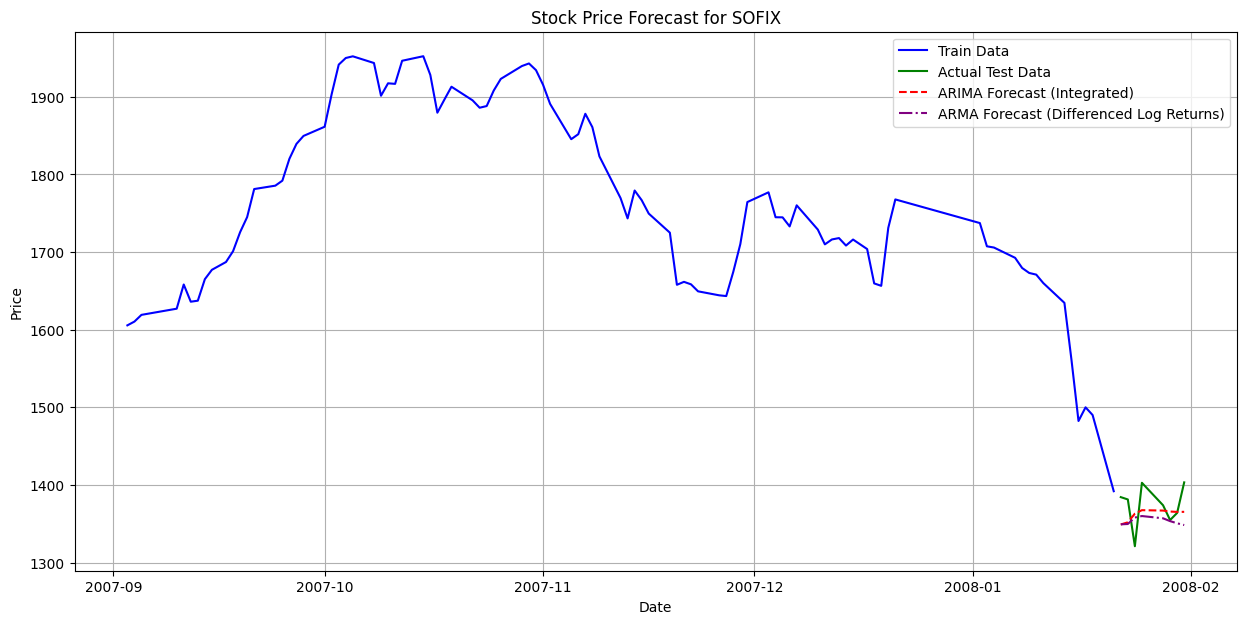

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


forecast_steps = len(test.dropna())


arima_price_forecast_raw = fit_ARIMA.forecast(steps=forecast_steps)
arima_price_forecast = pd.Series(arima_price_forecast_raw.values, index=test.dropna().index)


last_train_price = train.iloc[-1]
arma_lr_forecast_raw = fit_ARMA.forecast(steps=forecast_steps)
arma_lr_forecast = pd.Series(arma_lr_forecast_raw.values, index=test.dropna().index)


arma_price_forecast = last_train_price * np.exp(arma_lr_forecast.cumsum())

plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.dropna().index, test.dropna(), label='Actual Test Data', color='green')
plt.plot(arima_price_forecast.index, arima_price_forecast, label='ARIMA Forecast (Integrated)', color='red', linestyle='--')
plt.plot(arma_price_forecast.index, arma_price_forecast, label='ARMA Forecast (Differenced Log Returns)', color='purple', linestyle='-.')

plt.title(f'Stock Price Forecast for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [358]:
from sklearn.metrics import mean_squared_error

actual_test_data = test.dropna()

rmse_arima = np.sqrt(mean_squared_error(actual_test_data, arima_price_forecast))
print(f'RMSE for ARIMA Forecast: {rmse_arima:.2f}')

rmse_arma = np.sqrt(mean_squared_error(actual_test_data, arma_price_forecast))
print(f'RMSE for ARMA Forecast: {rmse_arma:.2f}')

RMSE for ARIMA Forecast: 29.00
RMSE for ARMA Forecast: 33.39
